In [3]:
#Imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage, misc

# SK-Learn
from skimage.feature import hog
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Image Directory
train_dir = 'Data/train/'
test_dir = 'Data/test/'

In [4]:
#Count the number of images in the different categories in training and test set
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3952      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


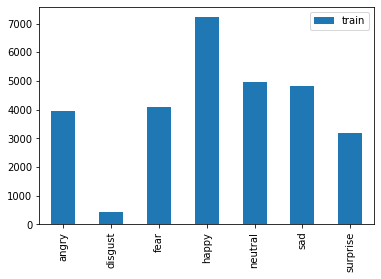

In [5]:
#Plot number of images in training set
train_count.transpose().plot(kind='bar')

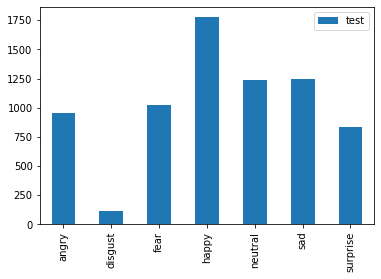

In [6]:
#Plot number of images in test set 
test_count.transpose().plot(kind='bar')

In [8]:
#Import pictures
def load_images_from_folder(folder):
    #create an integer value for each of 7 categories
    class_names = os.listdir(folder) # Get names of classes
    class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

    images, labels = [], []
    for expression in os.listdir(folder):
        path = folder + expression
        label_id = class_name2id[expression]
        #print(label_id)
      
        for filename in os.listdir(path):
            #print(filename)
            img = cv2.imread(path + '/' +filename)

            if img is not None:
                images.append(img)
                labels.append(label_id)
    return images, labels


In [10]:
class_names = os.listdir(train_dir) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

print(class_names)
#print(class_name2id['angry'])

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


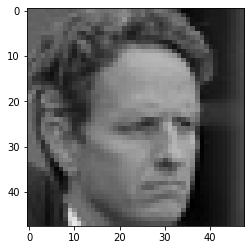

In [11]:
training, labels_training = load_images_from_folder(train_dir)
testing, labels_testing = load_images_from_folder(test_dir)

#Display first image in training data
img = training[0]
imgplot = plt.imshow(img)
plt.show()

## Preprocessing

In [16]:
#Method to perform equalization histogram on a list of images
def equalizing(images):
    equ_hist_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(img)
        equ_hist_images.append(equ)
    return equ_hist_images

#inputs a list of images and the filtervalue (often 3)
#outputs a new list of images with the median filter applied
def apply_median_filter(images, filter_value): 
    images_med = []
    for img in images:
        img_med = ndimage.median_filter(img, filter_value)
        images_med.append(img_med)
    return images_med


In [17]:
training_equalized = equalizing(training)
testing_equalized = equalizing(testing)

training_equ_med = apply_median_filter(training_equalized, 3)
testing_equ_med = apply_median_filter(testing_equalized, 3)

## Feature Extraction

In [18]:
#Caculate HoG for every image in data

hog_features_training = np.asarray([hog(image_training, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_training in training_equ_med])
hog_features_test = np.asarray([hog(image_test, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_test in testing_equ_med])

#print shape
print(hog_features_training.shape)
print(hog_features_test.shape)

(28666, 900)
(7178, 900)


In [ ]:
#Extract SIFT or SURF features from an images
def features(images): 
    #load all the algorithms 
    sift = cv2.xfeatures2d.SIFT_create()
    surf = cv2.xfeatures2d.SURF_create()
    
    images_keypoints = []
    images_descriptors = []
    for img in images:
        
        #get keypoints and descriptos from the image
        keypoints_sift, descriptors_sift = sift.detectAndCompute(img, None)
        keypoints_surf, descriptors_surf = surf.detectAndCompute(img, None)
        
        #save the keypoints and descriptors for each image
        images_keypoints.append(keypoints_sift)
        images_descriptors.append(descriptors_sift)
    
        #Draw keypoints on the image
        img_sift = cv2.drawKeypoints(img, keypoints_sift, None)
        img_surf = cv2.drawKeypoints(img, keypoints_surf, None)
    
        images_with_keypoints = [img_sift, img_surf]
    return images_keypoints, images_descriptors, images_with_keypoints

In [19]:
#Split up into training and test 
X_trn_hog = hog_features_training
Y_trn = labels_training 

X_test_hog = hog_features_test
Y_test = labels_testing 

## SVM Classifiers

HoG Accuracy: 0.4140429088882697


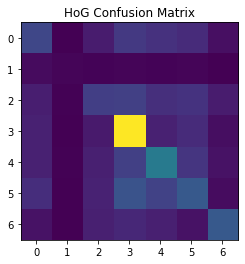

In [20]:
#Linear SVM
# create SVM models
svm_hog = svm.SVC(kernel='linear', gamma='scale')

# train SVM models
svm_hog.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
hog_predictions = svm_hog.predict(X_test_hog)
print('HoG Accuracy: {}'.format(accuracy_score(Y_test, hog_predictions))) 
plt.subplot(111), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('HoG Confusion Matrix')
plt.show()

In [ ]:
#speed up for svm ?
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [9]:
#Non-Linear SVMS - poly and rbf kernel

# create SVM models
svm_poly = svm.SVC(kernel='poly', gamma='scale')
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# train SVM models
svm_poly.fit(X_trn_hog, Y_trn)
svm_rbf.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
poly_predictions = svm_poly.predict(X_test_hog)
rbf_predictions = svm_rbf.predict(X_test_hog)
print('Polynomial Accuracy: {}'.format(accuracy_score(Y_test, poly_predictions)))
print('Radial Basis Function Accuracy: {}'.format(accuracy_score(Y_test, rbf_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_test, poly_predictions)), plt.title('Polynomial Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('RBF Confusion Matrix')
plt.show()

KeyboardInterrupt: 

## Random Forest Classifiers

Random Forest Accuracy: 0.4584842574533296


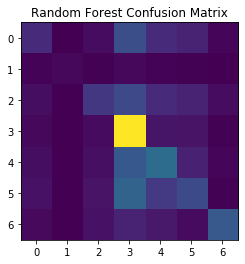

In [10]:
# create random forest classifier
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

# train classifier
rf.fit(X_trn_hog, Y_trn)

# evaluate classifier performance
rf_predictions = rf.predict(X_test_hog)
print('Random Forest Accuracy: {}'.format(accuracy_score(Y_test, rf_predictions)))
plt.imshow(confusion_matrix(Y_test, rf_predictions)), plt.title('Random Forest Confusion Matrix')
plt.show()

In [14]:
def randomForest(nbr_estimators_list):
    for nbr_estimator in nbr_estimators_list:
        # create random forest classifier
        rf = RandomForestClassifier(n_estimators=nbr_estimator, criterion='entropy')

        # train classifier
        rf.fit(X_trn_hog, Y_trn)

        # evaluate classifier performance
        rf_predictions = rf.predict(X_test_hog)
        print('Random Forest Accuracy: {}'.format(accuracy_score(Y_test, rf_predictions)))
        plt.imshow(confusion_matrix(Y_test, rf_predictions)), plt.title('Random Forest Confusion Matrix')
        plt.show()

Random Forest Accuracy: 0.44148787963220953


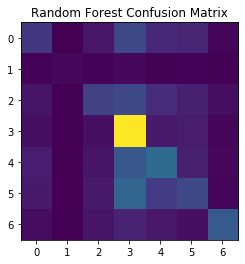

Random Forest Accuracy: 0.4653106714962385


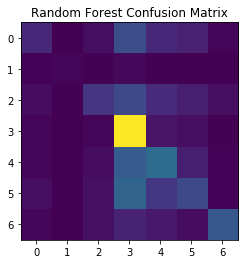

Random Forest Accuracy: 0.4706046252438005


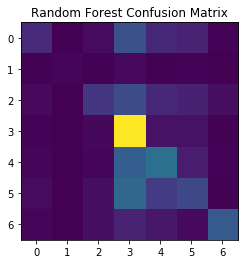

Random Forest Accuracy: 0.47199777096684314


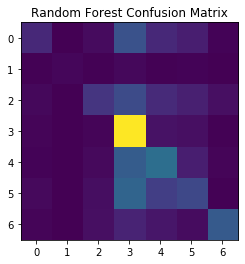

Random Forest Accuracy: 0.4763165227082753


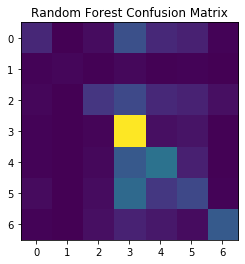

Random Forest Accuracy: 0.4725550292560602


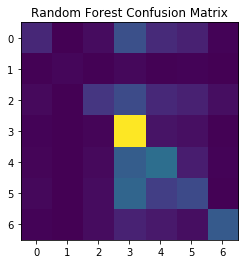

KeyboardInterrupt: 

In [15]:
nbr_estimators_list = [40, 200, 250, 300, 350, 400, 450, 500, 1000, 5000]
randomForest(nbr_estimators_list)

## Comparison of Classifiers

In [ ]:
#Performance Analysis

# predictions on training set for both classifiers
svm_rbf_trn_predictions = svm_rbf.predict(X_trn_hog)
rf_predictions = rf.predict(X_trn_hog)
print('SVM RBF Training Set Accuracy: {}'.format(accuracy_score(Y_trn, svm_rbf_trn_predictions)))
print('Random Forest 1000-tree Training Set Accuracy: {}'.format(accuracy_score(Y_trn, rf1000_trn_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_trn, svm_rbf_trn_predictions)), plt.title('SVM RBF Training Set')
plt.subplot(122), plt.imshow(confusion_matrix(Y_trn, rf1000_trn_predictions)), plt.title('RF 1000-tree Training Set')
plt.show()

# compare confusion matrices
print(np.subtract(confusion_matrix(Y_trn, svm_rbf_trn_predictions), confusion_matrix(Y_trn, rf1000_trn_predictions)))

# re-print test set results for convenience
print('Radial Basis Function Accuracy: {}'.format(accuracy_score(Y_test, rbf_predictions)))
print('Random Forest 1000-tree Accuracy: {}'.format(accuracy_score(Y_test, rf1000_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('RBF Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(Y_test, rf1000_predictions)), plt.title('RF 1000-tree')
plt.show()

# compare confusion matrices
print(np.subtract(confusion_matrix(Y_test, hog_predictions), confusion_matrix(Y_test, rf1000_predictions)))

In [ ]:
#TODO folded analysis